<a href="https://colab.research.google.com/github/trungdung211/KalapaMedicalQA/blob/dataset/Datasets/%5Bcolab%5D_Kalapa_Corpus_QA_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/MedicalMCQA-dh22

Mounted at /content/drive
/content/drive/MyDrive/MedicalMCQA-dh22


##**1. Process paragraph**

In [ ]:
# Read data
import os
import pandas as pd

corpus = []
file_names = []
for file_name in os.listdir('./data/corpus'):
    with open(f'./data/corpus/{file_name}', 'r') as f:
        doc = f.readlines()
    corpus.append(" ".join(doc))
    file_names.append(file_name)

test_data = pd.read_csv("./data/public_test.csv")

In [ ]:
import re
import string

def remove_url(text):
    return re.sub(r"http\S+", "", text)

def remove_poor_information_trunk(text):
    # remove BV TamAnh quote links
    text = re.sub(r"<blockquote>.*?</blockquote>", "", text)

    # remove BV TamAnh advertising portions
    text = remove_hospital_ads(text)
    return text

hospital_token_list = [
    "BVĐK Tâm Anh",
    "BVĐ K Tâm Anh",
    "BV Tâm Anh",
    "tại Tâm Anh",
    "Tại Tâm Anh",
    "Bệnh Viện Tâm Anh",
    "Bệnh Viện Đa Khoa Tâm Anh",
    "với Tâm Anh",
    "IVF Tâm Anh",
]
hospital_re_list = list(map(lambda token: re.compile("{}.*?(  |\.|\n|…)".format(token[::-1].lower()), re.IGNORECASE), hospital_token_list))
def remove_hospital_ads(doc):
    tail = doc[-2000:][::-1]
    start = 0
    for p in hospital_re_list:
        # res = re.search(p, tail)
        iter = re.finditer(p, tail)
        res = [m.start(1) for m in iter]
        if res:
            # index = res.start(1)
            index = max(res)
            if start < index:
                start = index
    return doc[:-start] if start > 0 else doc

def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

codes = ["&#8211", "&#038"]
def remove_special_token(text):
    for code in codes:
        text = text.replace(code, " ")
    return text

def remove_punctation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ')
    return text

def preprocess_text(text, remove_punc=True, remove_ads=False, is_lower=True):
    text = remove_url(text)
    if remove_ads:
        try:
            text = remove_poor_information_trunk(text)
        except:
            pass

    if remove_punc:
        text = " ".join(remove_punctation(remove_special_token(remove_html_tags(text))).split())
    else:
        text = " ".join(remove_special_token(remove_html_tags(text)).split())
    if is_lower:
        return text.lower()
    else:
        return text

In [ ]:
# Get title (or title + sub_title (menu))
codes = ["&#8211", "&#038"]
def get_titles(corpus):
    titles = []
    for doc in corpus:
        raw = doc.split("\n")[5]
        title = doc.split("\n")[5].split(":")[0].split("?")[0]
        for code in codes:
            title = title.replace(code, " ")
        title = preprocess_text(title)
        titles.append(title)
    return titles

titles = get_titles(corpus)
titles[0]

'đột quỵ thiếu máu cục bộ là gì'

In [ ]:
def split_doc(doc):
    try:
        paragraphs = doc.split("<h3>Mục lục</h3>")[1].split("<h2>")
    except:
        return []
    menu = paragraphs[0]
    paragraphs = paragraphs[1:]
    process_paragraphs = []
    for paragraph in paragraphs:
        if "hệ thống bệnh viện đa khoa tâm anh" in paragraph.lower():
            process_paragraph = paragraph.lower().split("hệ thống bệnh viện đa khoa tâm anh")[0]
            process_paragraph = paragraph[ : len(process_paragraph)]
        else:
            process_paragraph = paragraph
        process_paragraphs.append(process_paragraph)
    return process_paragraphs

**Split Paragraphs**

In [ ]:
import pandas as pd
import traceback

rows = []
for file_name, title, doc in zip(file_names, titles, corpus):
    for index, p in enumerate(split_doc(doc)):
        p = preprocess_text(str(p), remove_punc=True, remove_ads=True, is_lower=True)
        rows.append([file_name, title, index, p])

df = pd.DataFrame(rows, columns=['file_name', 'title', 'p_index', 'passage'])

df.to_csv('./data/all_paragraph.csv')

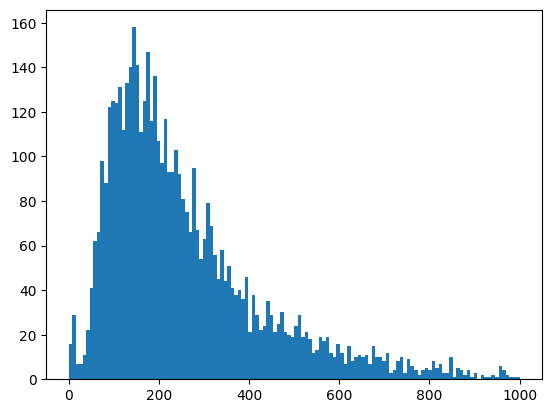

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(doc.split()) for doc in df["passage"]], bins=128, range=(0, 1000))
plt.show()

##**2. QA generation by VertexAI**

In [ ]:
!pip install google-cloud-aiplatform

In [ ]:
from vertexai.preview.language_models import TextGenerationModel
from google.colab import auth as google_auth

google_auth.authenticate_user(clear_output=True, project_id="dungvt22")

In [ ]:
from vertexai.preview.language_models import ChatModel, TextGenerationModel
from vertexai.language_models import InputOutputTextPair

chat_model = ChatModel.from_pretrained("chat-bison@001")

parameters = {
    "temperature": 0.2,
    "max_output_tokens": 600,
    "top_p": 0.95,
}

def get_question_from_passage(passage, parameters):
    context = "You are an Medical Question-Answering exam editor, you help me generate 5 multiple choices question-answers with correct answers from my given corpus. Each question should have 6 possible choices, question should be as short as possible. The question, answer, corpus are in Vietnamese. You return all the questions in your answer"
    corpus = passage

    examples = [
        InputOutputTextPair(
            input_text="User input",
            output_text="1. Question ?\nA. Choice 1\nB.Choice 2 ...\nCorrect: A, B ..."
        )
    ]
    chat = chat_model.start_chat(context=context, examples=examples)

    response = chat.send_message(
        corpus,
        **parameters)

    return response.text


In [ ]:
import pandas as pd

data = pd.read_csv('./data/all_paragraph.csv')

data.head()

,Unnamed: 0,file_name,title,p_index,passage
0,0,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,0,đột quỵ thiếu máu cục bộ là gì đột quỵ thiếu m...
1,1,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,1,các loại đột quỵ do thiếu máu cục bộ đột quỵ t...
2,2,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,2,nguyên nhân đột quỵ do thiếu máu cục bộ việc x...
3,3,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,3,triệu chứng của đột quỵ thiếu máu cục bộ các t...
4,4,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,4,biến chứng của đột quỵ do thiếu máu cục bộ đột...


In [ ]:
import re

def parse_vertex_ai_question(qa):
    questions = []
    question = ""
    choices_d = {}
    right_answers = []

    q_re = r'^\d+\.\s+(\w.+?)$'
    q_choice = r'^([A-F])\.\s+(\w.+)$'
    for line in qa.splitlines():
        if not line:
            continue
        line = line.strip()
        q = re.match(q_re, line)
        if q:
            question = q.group(1)
            continue
        c = re.match(q_choice, line)
        if c:
            choices_d[c.group(1)] = c.group(2)
            continue
        if line.startswith("Correct: "):
            right_answers = re.split(r',\s*', line[len("Correct: "):])
            questions.append({"question": question, "choices": choices_d, "righ_answers": right_answers})
            right_answers = []
            question = ""
            choices_d = {}
    return questions


In [ ]:
qa = get_question_from_passage(data.iloc[3]["passage"], parameters)
parse_vertex_ai_question(qa)

In [ ]:
data.iloc[8]["passage"]

'bệnh giun lươn là gì bệnh giun lươn strongyloides stercoralis được phát hiện đầu tiên ở nam bộ việt nam vào năm 1876 tần suất bệnh thực sự khó xác định vì phần lớn thường là nhiễm trùng tiềm ẩn 2 20 biểu hiện có thể thay đổi từ không triệu chứng đến suy đa cơ quan tử suất của người bệnh nhiễm giun lươn nhập 3viện 16 7 trên người suy giảm miễn dịch có thể gây bệnh lý nhiễm giun lươn lan tỏa gây tử vong bệnh có hai loại hình thái gồm giun lươn ký sinh và giun lươn sống tự do trong môi trường ngoài cơ thể ký chủ ấu trùng xâm nhập qua da vào hệ bạch huyết và hệ tĩnh mạch vào vòng tuần hoàn đến phổi khí quản thực quản dạ dày và phần đầu ruột non định vị tại đó ấu trùng khi đến phổi có thể không vào phế nang mà luân chuyển trong máu và đến các cơ quan khác trong quá trình di chuyển ấu trùng phải trải qua hai lần lột xác để trưởng thành giun trưởng thành thường sống ở tá hỗng tràng những trường hợp nhiễm nặng có thể gặp ở dạ dày môn vị đại tràng đường mật… mỗi giun trưởng thành có thể sống t

In [ ]:
from multiprocessing.pool import ThreadPool
import codecs
import json
import tqdm
import time
import random

file = codecs.open("lol", "w", "utf-8")
file.write(u'\ufeff')
file.close()

def task(args):
    file_name, p_index, passage = args
    total = []

    qa = get_question_from_passage(passage, parameters)
    questions = parse_vertex_ai_question(qa)
    total += questions

    return file_name, p_index, total

# create a thread pool
# pool = ThreadPool(processes=2)

items = [(row['file_name'], row['p_index'], row['passage']) for _, row in data.iterrows()]
random.shuffle(items)
print("N items %s" % len(items))

# file = codecs.open("./data/raw_generate_qa_by_passage.jsonl", "w", "utf-8")
results = []
# try:
#     for file_name, p_index, questions in tqdm.tqdm(pool.imap(task, items), total=len(items)):
#         r = {"file_name": file_name, "p_index": p_index, "questions": questions}
#         results.append(r)
#         # file.write(json.dumps(r, ensure_ascii=False) + '\n')
#         # file.flush()
# except Exception as e:
#     print(e)

def persist(results):
    with codecs.open("./data/raw_generate_qa_by_passage.jsonl", "a", "utf-8") as f:
        for r in results:
            f.write(json.dumps(r, ensure_ascii=False))
            f.write('\n')

for args in tqdm.tqdm(items):
    try:
        file_name, p_index, questions = task(args)
        time.sleep(5)
        r = {"file_name": file_name, "p_index": p_index, "questions": questions}
        results.append(r)
    except Exception as e:
        print("Error " + str(e))
        persist(results)
        results = []

        time.sleep(120)
        print("Retry ...")
        continue

    if len(results) >= 10:
        persist(results)
        results = []



N items 4975


  3%|▎         | 139/4975 [20:58<12:02:19,  8.96s/it]

Error 400 Invalid message. 


  3%|▎         | 140/4975 [22:59<56:51:13, 42.33s/it]

Retry ...


  6%|▌         | 299/4975 [47:05<12:24:55,  9.56s/it]

Error 500 Internal error encountered.


  6%|▌         | 300/4975 [49:09<56:53:45, 43.81s/it]

Retry ...


  9%|▉         | 465/4975 [1:14:29<15:42:35, 12.54s/it]

Error 400 Invalid message. 


  9%|▉         | 466/4975 [1:16:29<56:08:35, 44.82s/it]

Retry ...


 21%|██▏       | 1060/4975 [2:47:23<9:52:59,  9.09s/it] 

Error 400 Invalid message. 


 21%|██▏       | 1061/4975 [2:49:23<46:06:53, 42.42s/it]

Retry ...


 69%|██████▊   | 3413/4975 [8:46:53<3:59:38,  9.21s/it]

Error 500 Internal error encountered.


 69%|██████▊   | 3414/4975 [8:49:02<19:32:40, 45.07s/it]

Retry ...


100%|██████████| 4975/4975 [12:45:41<00:00,  9.23s/it]


In [ ]:
with codecs.open("./data/raw_generate_qa_by_passage.jsonl", "r", "utf-8") as f:
    for line in f:
        print(json.loads(line))

##**3. Postprocess QA**

### **3.1. Run cosin similarity**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/MedicalMCQA-dh22

Mounted at /content/drive
/content/drive/MyDrive/MedicalMCQA-dh22


In [ ]:
# Load data
import pandas as pd

all_paragraph = pd.read_csv('./data/all_paragraph.csv')
all_paragraph.head()

,Unnamed: 0,file_name,title,p_index,passage
0,0,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,0,đột quỵ thiếu máu cục bộ là gì đột quỵ thiếu m...
1,1,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,1,các loại đột quỵ do thiếu máu cục bộ đột quỵ t...
2,2,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,2,nguyên nhân đột quỵ do thiếu máu cục bộ việc x...
3,3,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,3,triệu chứng của đột quỵ thiếu máu cục bộ các t...
4,4,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,4,biến chứng của đột quỵ do thiếu máu cục bộ đột...


In [ ]:
import json

all_question = []
with open("./data/raw_generate_qa_by_passage.jsonl", "r") as f:
    all_question = list(map(lambda doc: json.loads(doc), f.readlines()))

all_question[0]

{'file_name': 'ung-thu-dai-trang',
 'p_index': 3,
 'questions': [{'question': 'Nguyên nhân nào sau đây không phải là yếu tố nguy cơ gây ung thư đại tràng?',
   'choices': {'A': 'Thừa cân hoặc béo phì',
    'B': 'Lối sống thiếu vận động',
    'C': 'Chế độ ăn uống không khoa học',
    'D': 'Hút thuốc lá',
    'E': 'Uống nhiều rượu bia'},
   'righ_answers': ['C']},
  {'question': 'Ung thư đại tràng có thể gây ra những triệu chứng nào sau đây?',
   'choices': {'A': 'Đau bụng',
    'B': 'Chảy máu trực tràng',
    'C': 'Táo bón',
    'D': 'Cả A và B',
    'E': 'Cả A, B và C'},
   'righ_answers': ['E']},
  {'question': 'Ung thư đại tràng có thể được điều trị bằng những phương pháp nào sau đây?',
   'choices': {'A': 'Phẫu thuật',
    'B': 'Hóa trị',
    'C': 'Xạ trị',
    'D': 'Cả A, B và C',
    'E': 'Cả A, B, C và D'},
   'righ_answers': ['E']},
  {'question': 'Ung thư đại tràng có thể được phòng ngừa bằng cách nào sau đây?',
   'choices': {'A': 'Tầm soát ung thư đại tràng',
    'B': 'Tuân t

**Cosine** Similarity

In [ ]:
!pip install transformers sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.2 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=1bf508cb4b81c74818912f4a68853d2d7dcfe583214a8a69b081db86c9056c49
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["Cô giáo đang ăn kem", "Chị gái đang thử món thịt dê"]

model = SentenceTransformer('keepitreal/vietnamese-sbert')
embeddings = model.encode(sentences)
print(embeddings)

[[ 0.5584592   0.11873563 -0.03774043 ... -0.0916012   0.27377504
  -0.01684714]
 [ 0.6878686  -0.30957296 -0.08320777 ...  0.26208174  0.04669749
   0.01583396]]


In [ ]:
# Get top passage
from sentence_transformers import SentenceTransformer, util

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def embed_passage(passages, tokenizer, model, device='cpu'):
    # Tokenize sentences
    encoded_input = tokenizer(passages, padding=True, truncation=True, return_tensors='pt')

    model = model.to(device)
    encoded_input.to(device)
    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    # Perform pooling
    passage_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    return passage_embeddings

def get_cos_score_vs_passage(questions, passage, tokenizer, model, device='cpu'):
    passage_embedding = embed_passage([passage], tokenizer, model, device)

    question_embeddings = embed_passage(questions, tokenizer, model, device)

    cos_scores = util.cos_sim(passage_embedding, question_embeddings)[0].numpy().tolist()

    return cos_scores


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

model_name = 'xlm-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
qt = all_question[1]

questions0 = list(map(lambda doc: doc['question'], qt['questions']))
for q in questions0:
    print(q)

passage = all_paragraph[(all_paragraph['file_name'] == qt['file_name']) & (all_paragraph['p_index'] == qt['p_index'])]
print(passage.iloc[0]["passage"])

get_cos_score_vs_passage(questions0, passage.iloc[0]["passage"], tokenizer, model)

Chuyển dạ đình trệ có thể gây ra những nguy cơ gì cho mẹ và bé?
Để phòng ngừa chuyển dạ đình trệ, mẹ bầu cần lưu ý những điều gì?
Mẹ bầu nên thực hiện thăm khám thai đều đặn theo khuyến cáo của bác sĩ để làm gì?
Mẹ bầu nên duy trì chế độ ăn khi mang thai với đầy đủ dinh dưỡng để làm gì?
Mẹ bầu nên tiêm phòng đầy đủ để làm gì?
biện pháp phòng ngừa để giảm nguy cơ chuyển dạ đình trệ ảnh hưởng đến sức khỏe của chính mình và em bé mẹ bầu cần lưu ý 4 thực hiện thăm khám thai đều đặn theo khuyến cáo của bác sĩ để có một thai kỳ khỏe mạnh thai phụ cần ghi nhớ những mốc khám thai quan trọng trong thai kỳ các mốc khám thai sẽ liên quan đến việc giúp bác sĩ phát hiện được những nguy cơ của thai kỳ đưa ra những lời khuyên hữu ích về tình trạng của mẹ bầu hiện tại từ đó có thể có những phương án dự phòng tối ưu cho mẹ bầu và thai nhi duy trì chế độ ăn khi mang thai với đầy đủ dinh dưỡng hạn chế ăn những thực phẩm đóng gói sẵn chứa nhiều chất bảo quản… bổ sung thêm trái cây sắt và canxi theo chỉ đị

tensor([0.9937, 0.9936, 0.9954, 0.9952, 0.9903])

Get top questions

In [ ]:
import tqdm
import codecs
import json
import random

all_processed_questions = []
random.shuffle(all_question)

for qt in tqdm.tqdm(all_question):
    questions0 = list(map(lambda doc: doc['question'], qt['questions']))
    passage = all_paragraph[(all_paragraph['file_name'] == qt['file_name']) & (all_paragraph['p_index'] == qt['p_index'])]
    if passage.empty or not passage.iloc[0]["passage"] or not questions0:
        continue
    cos_similarity = get_cos_score_vs_passage(questions0, passage.iloc[0]["passage"], tokenizer, model)

    for q, cos in zip(qt['questions'], cos_similarity):
        q.update({
            'file_name': qt['file_name'],
            'p_index': qt['p_index'],
            'cos_sim': cos,
        })
        all_processed_questions.append(q)

print(all_processed_questions[0])
print(len(all_processed_questions))

with codecs.open("./data/ranked_qa_data.jsonl", "w", "utf-8") as f:
    for r in all_processed_questions:
        f.write(json.dumps(r, ensure_ascii=False))
        f.write('\n')

100%|██████████| 4970/4970 [1:28:08<00:00,  1.06s/it]


{'question': 'Mụn trứng cá ở lưng là gì?', 'choices': {'A': 'Là những mụn trứng cá hình thành và phát triển ở vùng lưng.', 'B': 'Là những mụn trứng cá hình thành và phát triển ở vùng lưng trên.', 'C': 'Là những mụn trứng cá hình thành và phát triển ở vùng lưng trên và cánh tay.', 'D': 'Là những mụn trứng cá hình thành và phát triển ở vùng lưng trên và cánh tay và có thể là mụn đầu đen, mụn đầu trắng, mụn thịt hoặc u nang.', 'E': 'Là những mụn trứng cá hình thành và phát triển ở vùng lưng trên và cánh tay và có thể là mụn đầu đen, mụn đầu trắng, mụn thịt hoặc u nang và 1 mụn ở lưng có thể bao gồm nhiều loại mụn khác nhau.'}, 'righ_answers': ['D', 'E.'], 'file_name': 'mun-trung-ca-o-lung', 'p_index': 0, 'cos_sim': 0.9928287863731384}
19012


###**3.2. Rank Question Answer**

In [151]:
import json

all_question = []
with open("./data/ranked_qa_data.jsonl", "r") as f:
    all_question = list(map(lambda doc: json.loads(doc), f.readlines()))

all_question[0]

{'question': 'Mụn trứng cá ở lưng là gì?',
 'choices': {'A': 'Là những mụn trứng cá hình thành và phát triển ở vùng lưng.',
  'B': 'Là những mụn trứng cá hình thành và phát triển ở vùng lưng trên.',
  'C': 'Là những mụn trứng cá hình thành và phát triển ở vùng lưng trên và cánh tay.',
  'D': 'Là những mụn trứng cá hình thành và phát triển ở vùng lưng trên và cánh tay và có thể là mụn đầu đen, mụn đầu trắng, mụn thịt hoặc u nang.',
  'E': 'Là những mụn trứng cá hình thành và phát triển ở vùng lưng trên và cánh tay và có thể là mụn đầu đen, mụn đầu trắng, mụn thịt hoặc u nang và 1 mụn ở lưng có thể bao gồm nhiều loại mụn khác nhau.'},
 'righ_answers': ['D', 'E.'],
 'file_name': 'mun-trung-ca-o-lung',
 'p_index': 0,
 'cos_sim': 0.9928287863731384}

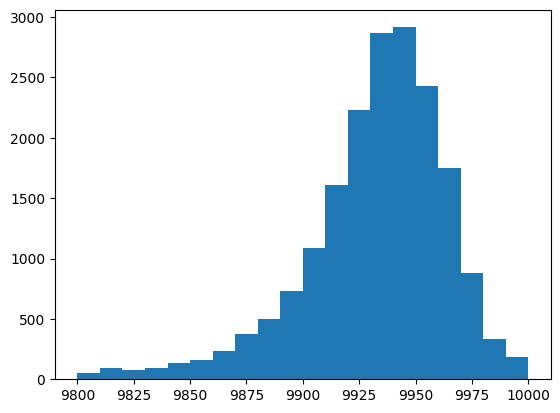

In [152]:
import matplotlib.pyplot as plt
plt.hist([doc['cos_sim']*10000 for doc in all_question], bins=20, range=(9800, 10000))
plt.show()

In [153]:
# all_question = list(
#     filter(lambda q: q["file_name"] == "viem-tai-xuong-chum" and q["p_index"] == 4, all_question)
# )
# all_question[0]

In [154]:
cos_sim_threshold = 0.99
choosen_questions = list(filter(lambda doc: doc["cos_sim"] >= 0.99 and len(doc["choices"].keys()) > 1, all_question))
# choosen_questions = choosen_questions[:1]
# print(choosen_questions)

all_question_clean = []
all_questions_set = set()
for q in choosen_questions:
    letters = ["A", "B", "C", "D", "E", "F"]
    choices = {}
    for c in letters:
        if c not in q["choices"]:
            break
        for p in ["không rõ", "không thể trả lời", "không có đáp án nào đúng", "có thể", "không thể"]:
            if p in q["choices"][c].lower():
                break
        choices[c] = q["choices"][c]
    q["choices"] = choices
    # validate questions
    if len(choices.keys()) == 0:
        continue
    if len(
        set(q["righ_answers"]).difference(set(q["choices"].keys()))
        ) > 0:
        continue
    # don't use question which is too long and yes/no question
    if (len(q["question"]) >= 320 or not q["question"].strip().endswith("?")):
        continue
    if q["question"] in all_questions_set:
        continue
    # filter out only single answer
    if len(q["righ_answers"]) > 1:
        continue
    # filter out "Tất cả", "đều đúng", "đều sai"...
    bypass = False
    for ops in q["choices"].values():
        # ad-hoc removing
        if ops == "Ăn nhiều thịt dê":
            bypass = True
            break
        for p in ["tất cả", "đều đúng", "đều sai", "phương án trên", "đáp án trên"]:
            if p in ops.lower():
                bypass = True
                break
        if ops.lower().startswith("cả") and "và" in ops.lower():
            bypass = True
            break
        if len(ops) > 120:
            bypass = True
            break
    if bypass:
        # print("bypass")
        # print(q["choices"])
        continue
    all_questions_set.add(q["question"])
    # append to all
    all_question_clean.append(q)

print(len(all_question_clean))

4223


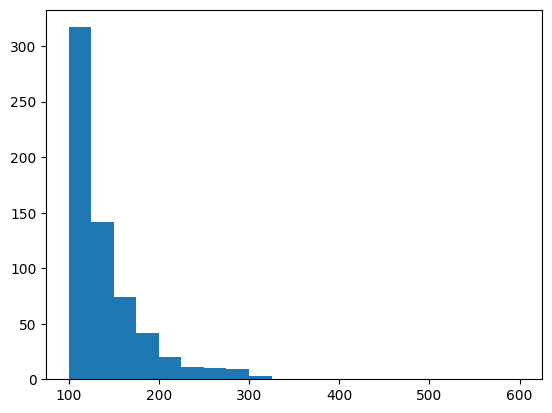

In [155]:
import matplotlib.pyplot as plt
import json
# plt.hist([len(json.dumps(doc)) for doc in all_question_clean], bins=20, range=(200, 600))
plt.hist([len(doc["question"]) for doc in all_question_clean], bins=20, range=(100, 600))
plt.show()

In [156]:
import random

count = 0
file_name_d = {}
fn_d_rev = {}
count_d = {}
group_d = {}

for q in all_question_clean:
    fn = q["file_name"]
    if fn not in file_name_d:
        file_name_d[fn] = count
        fn_d_rev[count] = fn
        count += 1
    q["all_index"] = file_name_d[fn]*100
    count_d[fn] = count_d.get(fn, 0) + 1
    group_d[fn] = group_d.get(fn, []) + [q]

# plt.hist([doc["all_index"] for doc in all_question_clean], bins=50, range=(100, 60000))
# plt.show()

# sorted([(k, v) for k, v in count_d.items()], key=lambda x: x[1], reverse=True)

balanced_list = []
for fn, qs in group_d.items():
    random.shuffle(qs)
    balanced_list.extend(qs[:12])

all_question_clean = balanced_list
len(all_question_clean)

3974

### **3.2. Write cleaned dataset**

In [157]:
import pandas as pd

data = pd.read_csv('./data/all_paragraph.csv')
data.head()

,Unnamed: 0,file_name,title,p_index,passage
0,0,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,0,đột quỵ thiếu máu cục bộ là gì đột quỵ thiếu m...
1,1,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,1,các loại đột quỵ do thiếu máu cục bộ đột quỵ t...
2,2,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,2,nguyên nhân đột quỵ do thiếu máu cục bộ việc x...
3,3,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,3,triệu chứng của đột quỵ thiếu máu cục bộ các t...
4,4,dot-quy-thieu-mau-cuc-bo,đột quỵ thiếu máu cục bộ là gì,4,biến chứng của đột quỵ do thiếu máu cục bộ đột...


In [158]:
import codecs
import json

def format_question(q):
    try:
        exp = data[(data["file_name"] == q["file_name"]) & (data["p_index"] == q["p_index"])].iloc[0]["passage"]
        return {
            "question": q["question"],
            "p_index": q["p_index"],
            "file_name": q["file_name"],
            # "exp": exp,
            "opa": q["choices"]["A"],
            "opb": q["choices"]["B"],
            "opc": q["choices"].get("C"),
            "opd": q["choices"].get("D"),
            "ope": q["choices"].get("E"),
            "cop": [ord(op[0]) - ord('A') for op in q["righ_answers"]]
        }
    except Exception as e:
        print(q)
        raise e

results = [format_question(q) for q in all_question_clean]

with codecs.open("./data/qa_data_clean_single.jsonl", "w", "utf-8") as f:
    for r in results:
        f.write(json.dumps(r, ensure_ascii=False))
        f.write('\n')
